In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Étape 1: Chargement des bibliothèques nécessaires**


---


Description: Dans cette étape, nous allons importer les bibliothèques Python nécessaires pour manipuler et analyser les données.

In [ ]:
# Importation des bibliothèques nécessaires
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from matplotlib import pyplot as plt
from IPython.display import display


**Étape 2: Chargement et exploration des données.**


---
Description: Nous allons charger le fichier JSON contenant les données CVE, extraire les informations pertinentes et les stocker dans un DataFrame pandas pour une analyse plus approfondie.

In [ ]:
# Chargement du fichier JSON depuis Google Drive
file_path = '/content/drive/MyDrive/nvdcve-1.1-2003.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Extraction des informations pertinentes
cve_items = data['CVE_Items']
cve_data = []
for item in cve_items:
    cve_id = item['cve']['CVE_data_meta']['ID']
    description = item['cve']['description']['description_data'][0]['value']
    published_date = item['publishedDate']
    impact_score = item.get('impact', {}).get('baseMetricV2', {}).get('impactScore', None)
    severity = item.get('impact', {}).get('baseMetricV2', {}).get('severity', None)
    cve_data.append([cve_id, description, published_date, impact_score, severity])

# Création d'un DataFrame
df = pd.DataFrame(cve_data, columns=['CVE_ID', 'Description', 'Published_Date', 'Impact_Score', 'Severity'])

# Affichage de l'ensemble du DataFrame
display(df)

,CVE_ID,Description,Published_Date,Impact_Score,Severity
0,CVE-2003-0001,Multiple ethernet Network Interface Card (NIC)...,2003-01-17T05:00Z,2.9,MEDIUM
1,CVE-2003-0002,Cross-site scripting vulnerability (XSS) in Ma...,2003-02-07T05:00Z,6.4,MEDIUM
2,CVE-2003-0003,Buffer overflow in the RPC Locator service for...,2003-02-07T05:00Z,6.4,HIGH
3,CVE-2003-0004,Buffer overflow in the Windows Redirector func...,2003-02-19T05:00Z,10.0,HIGH
4,CVE-2003-0007,Microsoft Outlook 2002 does not properly handl...,2003-02-07T05:00Z,2.9,MEDIUM
...,...,...,...,...,...
1548,CVE-2003-1604,The redirect_target function in net/ipv4/netfi...,2016-05-02T10:59Z,6.9,HIGH
1549,CVE-2003-1605,curl 7.x before 7.10.7 sends CONNECT proxy cre...,2018-08-23T19:29Z,2.9,MEDIUM
1550,CVE-2003-5001,A vulnerability was found in ISS BlackICE PC P...,2022-03-28T21:15Z,6.4,HIGH
1551,CVE-2003-5002,A vulnerability was found in ISS BlackICE PC P...,2022-03-28T21:15Z,2.9,MEDIUM


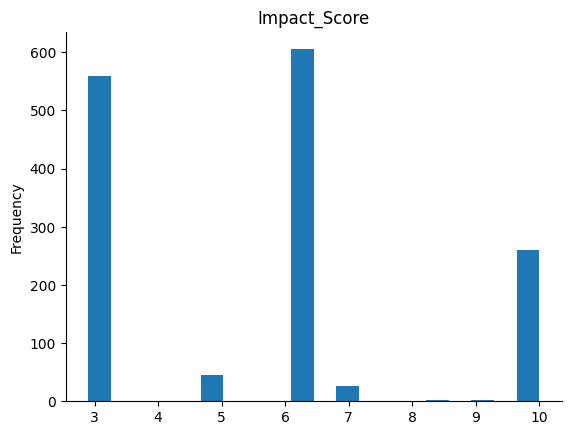

In [ ]:
# Plotting the histogram for Impact_Score
df['Impact_Score'].plot(kind='hist', bins=20, title='Impact_Score')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


**Étape 3: Prétraitement des données**


---
Description: Nous allons nettoyer les données, gérer les valeurs manquantes et préparer les caractéristiques pour la modélisation.

In [ ]:
# Gestion des valeurs manquantes
df['Impact_Score'] = df['Impact_Score'].fillna(0)
df['Severity'] = df['Severity'].fillna('UNKNOWN')

# Transformation des dates en format datetime
df['Published_Date'] = pd.to_datetime(df['Published_Date'])

# Affichage des informations sur les données après le prétraitement
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1553 entries, 0 to 1552
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   CVE_ID          1553 non-null   object             
 1   Description     1553 non-null   object             
 2   Published_Date  1553 non-null   datetime64[ns, UTC]
 3   Impact_Score    1553 non-null   float64            
 4   Severity        1553 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), object(3)
memory usage: 60.8+ KB


**Étape 4: Extraction des caractéristiques textuelles**


---
Description: Utilisation de la technique TF-IDF pour transformer les descriptions textuelles en vecteurs numériques.

In [ ]:

# Initialisation du vecteur TF-IDF
tfidf = TfidfVectorizer(max_features=1000)

# Transformation des descriptions en vecteurs TF-IDF
X = tfidf.fit_transform(df['Description']).toarray()

# Affichage de la forme de la matrice de caractéristiques
print("Forme de la matrice de caractéristiques après transformation TF-IDF : ", X.shape)


Forme de la matrice de caractéristiques après transformation TF-IDF :  (1553, 1000)


**Étape 5: Préparation des étiquettes et division des données.**


---
Description: Nous allons préparer les étiquettes (scores d'impact) et diviser les données en ensembles d'entraînement et de test.

In [ ]:
# Préparation des étiquettes
y = df['Impact_Score']

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Affichage des tailles des ensembles d'entraînement et de test
print(f"Taille de l'ensemble d'entraînement: {X_train.shape[0]} échantillons")
print(f"Taille de l'ensemble de test: {X_test.shape[0]} échantillons")


Taille de l'ensemble d'entraînement: 1242 échantillons
Taille de l'ensemble de test: 311 échantillons


**Étape 6: Entraînement du modèle de prédiction des vulnérabilités.**


---
Description : Entraînement d'un modèle de machine learning spécifique pour prédire les vulnérabilités à partir des données CVE.

Résultats des prédictions :
[4.492      5.093      3.843      5.453      4.296      4.874
 3.616      7.197      8.02       6.4        6.134      6.467
 6.691      3.15       9.337      6.616      7.631      6.884
 3.428      4.718      6.826      4.594      3.731      4.665
 4.552      6.843      3.566      4.694      5.69       6.436
 4.036      3.525      8.418      7.12       7.469      7.298
 3.096      4.815      8.452      7.935      3.925      3.365
 6.343      4.472      4.838      6.31166667 7.588      5.667
 3.11       3.67       3.29       6.009      4.21       3.483
 3.005      7.554      5.86       7.949      3.576      3.015
 8.473      6.689      6.619      5.942      0.         4.336
 7.391      6.869      6.402      8.603      3.         5.629
 5.866      3.926      7.04       7.35958333 6.811      3.574
 3.186      5.094      3.595      6.193      3.06       3.165
 7.984      7.295      6.11       6.688      3.09       4.251
 6.783      3.218      6.175      3.05    

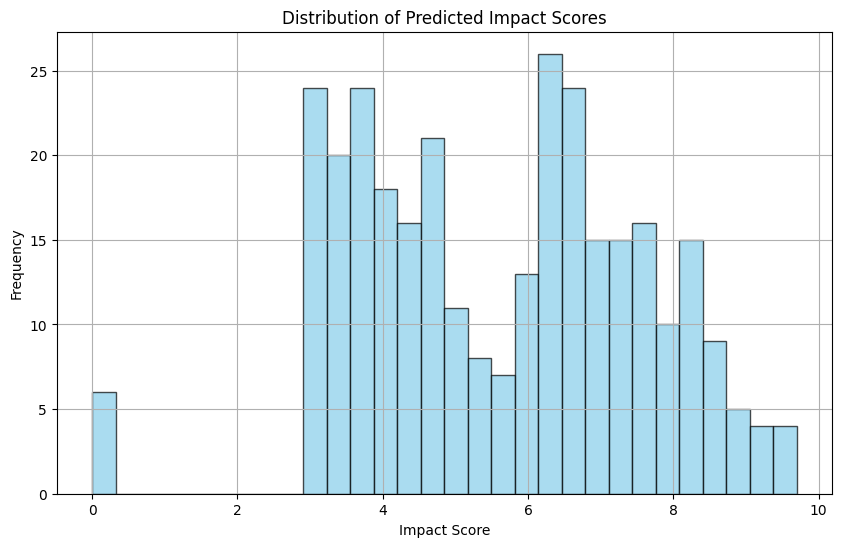

In [ ]:
# Importation du modèle spécifique pour la prédiction des vulnérabilités
from sklearn.ensemble import RandomForestRegressor

# Initialisation du modèle
model = RandomForestRegressor()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)
print("Résultats des prédictions :")
print(y_pred)



# Plotting the histogram for predicted impact scores
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Predicted Impact Scores')
plt.xlabel('Impact Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



Donc Les prédictions du modèle Random Forest montrent une distribution variée des scores d'impact des vulnérabilités, avec des valeurs allant de 0 à 9.7, indiquant que le modèle a capturé une large gamme de scores d'impact possibles

Étape 7: Évaluation du modèle de prédiction des vulnérabilités.


---
Description : Évaluation de la performance du modèle de prédiction des vulnérabilités à l'aide de métriques appropriées.

In [ ]:
# Calcul de l'erreur quadratique moyenne (MSE - Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# Calcul de l'erreur absolue moyenne (MAE - Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# Affichage des résultats
print(f"Erreur quadratique moyenne (MSE) : {mse}")
print(f"Erreur absolue moyenne (MAE) : {mae}")



Erreur quadratique moyenne (MSE) : 2.907483719386386
Erreur absolue moyenne (MAE) : 1.2985495712754536


**Évaluation des performances des modèles de prédiction des vulnérabilités**


---

Description : Cette étape consiste à évaluer les performances des différents modèles de prédiction des vulnérabilités en calculant les erreurs quadratiques moyennes (MSE) et les erreurs absolues moyennes (MAE) pour chaque modèle.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Évaluation des performances de chaque modèle
mse_rf = mean_squared_error(y_test, random_forest_predictions)
mae_rf = mean_absolute_error(y_test, random_forest_predictions)

mse_svm = mean_squared_error(y_test, svm_predictions)
mae_svm = mean_absolute_error(y_test, svm_predictions)

mse_nn = mean_squared_error(y_test, neural_network_predictions)
mae_nn = mean_absolute_error(y_test, neural_network_predictions)

mse_knn = mean_squared_error(y_test, knn_predictions)
mae_knn = mean_absolute_error(y_test, knn_predictions)

# Affichage des résultats
print("Résultats de la performance des modèles :")
print("Random Forest:")
print(f"MSE : {mse_rf}")
print(f"MAE : {mae_rf}")

print("\nSVM:")
print(f"MSE : {mse_svm}")
print(f"MAE : {mae_svm}")

print("\nNeural Network:")
print(f"MSE : {mse_nn}")
print(f"MAE : {mae_nn}")

print("\nk-Nearest Neighbors:")
print(f"MSE : {mse_knn}")
print(f"MAE : {mae_knn}")


Résultats de la performance des modèles :
Random Forest:
MSE : 2.844671305778848
MAE : 1.2902009646302233

SVM:
MSE : 3.464535837321424
MAE : 1.4226178482520249

Neural Network:
MSE : 5.337188217443885
MAE : 1.777032794756101

k-Nearest Neighbors:
MSE : 4.294032154340836
MAE : 1.5962700964630223


1- Le modèle Random Forest a les meilleures performances avec les erreurs MSE et MAE les plus faibles, indiquant une précision supérieure pour prédire les scores d'impact des vulnérabilités.

2- Le modèle SVM a des performances légèrement inférieures à celles de Random Forest, avec des erreurs MSE et MAE plus élevées, indiquant une précision moindre pour les prédictions de scores d'impact.

3- Le modèle k-NN a des performances intermédiaires, avec des erreurs supérieures à celles de Random Forest et SVM mais inférieures à celles du Neural Network, montrant une capacité de prédiction modérée.